# Baseline algorithm: the z‑score mean‑reversion strategy

Applying statistical modeling for algorithmic trading on single currency.
We will use simple Z-score Mean Reversion algorithm

Main code is placed in `pipelines/z_score_mean_reversion`

On short horizons, the (log) price of a asset tends to fluctuate around a local level with predictable deviation. If the current log‑price is *significantly* below its recent average, a reversion upward is expected; if it is significantly above, a reversion downward is expected. Statistical significance is quantified via a **z‑score**—the number of standard deviations the current log‑price deviates from its rolling mean.

The principal assumption is *local stationarity* over a rolling window of length $W$: within that window, first and second moments are approximately stable, so a rolling mean and variance are meaningful normalizers. Trend‑dominated regimes violate this assumption; therefore, we employ risk controls (position caps), a neutrality band, volatility targeting, and **next‑bar** execution to keep the backtest honest.

## How the z‑score mean‑reversion strategy works

### Intuition and assumptions


On short horizons, the (log) price of a liquid asset tends to fluctuate around a local level. If the current log‑price is *significantly* below its recent average, a reversion upward is expected; if it is significantly above, a reversion downward is expected. Statistical significance is quantified via a **z‑score**—the number of standard deviations the current log‑price deviates from its rolling mean.

The principal assumption is *local stationarity* over a rolling window of length $W$: within that window, first and second moments are approximately stable, so a rolling mean and variance are meaningful normalizers. Trend‑dominated regimes violate this assumption; therefore, we employ risk controls (position caps), a neutrality band, volatility targeting, and **next‑bar** execution to keep the backtest honest.

### Formal model



Let $P_t$ be the closing price at time $t$ on a uniform time grid (UTC) (next we will assume this interval to be 1 day). Define the working variable (log‑price) and log‑return as
$$
p_t = \ln P_t, \quad r_{t+1} = p_{t+1} - p_t.
$$
For each $t \ge W$, compute right‑aligned rolling statistics (using only $\mathcal F_t$ information):
$$
\mu_t = \frac{1}{W}\sum_{i=0}^{W-1} p_{t-i}, \qquad
\sigma_t = \sqrt{\frac{1}{W-1} \sum_{i=0}^{W-1} (p_{t-i} - \mu_t)^2},
$$
and the standardized deviation (z‑score):
$$
z_t = \frac{p_t - \mu_t}{\sigma_t}.
$$

The side to exchange (buy, sell, hold) is obtained from successive logic:
$$
\textrm{side}_t = \begin{cases}
+1, \,\, z_t \leq -\theta, \\
-1, \,\, z_t \geq \theta, \\
0, \,\,\, |z_t| \in [-\theta, \theta]
\end{cases}
$$

Where $\theta$ – defined threshold, derived from Z - normal (student if you want) survival function via percentile of your allowed risk

# Code implementation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
from pathlib import Path

# setup path to project root
sys.path.append(str(Path.cwd().parent))

## PipeLine construction

load config and set seeds

In [2]:
from typing import Dict, Any, Optional
from pathlib import Path
import numpy as np
import random
import torch
import yaml

def load_config(path: Optional[Path] = None) -> Dict[str, Any]:
    if path is None:
        path = Path(__file__).with_name("config.yaml")
    with path.open("r", encoding="utf-8") as f:
        return yaml.safe_load(f)

def set_global_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    if torch is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

config_path = Path('../pipelines/z_score_mean_reversion/config.yaml').resolve().absolute()
config = load_config(Path(config_path) if config_path else None)

seed = int(config.get("seed", 42))
set_global_seed(seed)

We do trade on close prices of previous day. So now we download historical data for configured currency

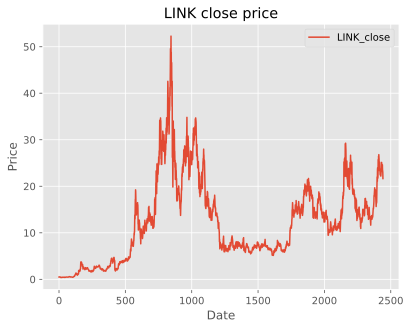

In [3]:
# tools for loading data
from pipelines.z_score_mean_reversion.data_loader import build_data_loader

data_loader = build_data_loader(config["data"])
price_frame = data_loader.load()

# visualize price
ax = price_frame[f"{config['data']['currency']}_close"].plot(x="date", y="close")
ax.set_title(f"{config['data']['currency']} close price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.legend()
ax.figure.show()

Next we create env over downloaded data (for any currecny we assume 8 digit precision)

In [4]:
import tensortrade.env.default as default
from tensortrade.env.default import actions as action_api, rewards as reward_api
from tensortrade.env.default.renderers import construct_renderers
from tensortrade.feed.core import DataFeed, NameSpace, Stream
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Portfolio, Wallet
from tensortrade.oms.instruments import Instrument, registry
import pandas as pd


def build_environment(
    data: pd.DataFrame,
    env_config: Dict[str, Any],
    currency: str,
    main_currency: str,
):
    exchange_name = "simulator"
    commission = env_config.get("fee_rate")

    # prepare two instruments: USDT and currency
    if main_currency not in registry:
        Instrument(main_currency, 2, main_currency)
    base_instrument = registry[main_currency]

    if currency not in registry:
        registry[currency] = Instrument(currency, 8, currency)
    asset_instrument = registry[currency]

    # we do trade on close prices of previous day
    price_column = f"{currency}_close"
    price_stream = Stream.source(list(data[price_column]), dtype="float").rename(
        f"{main_currency}-{currency}"
    )

    # create exchange manager, simulating currency swapping between us and platform
    options = ExchangeOptions(commission=commission)
    exchange = Exchange(exchange_name, service=execute_order, options=options)(price_stream)

    # creation of wallets for cash and asset
    initial_cash = float(env_config.get("initial_cash", 0.0))
    initial_amount = float(env_config.get("initial_amount", 0.0))

    cash_wallet = Wallet(exchange, initial_cash * base_instrument)
    asset_wallet = Wallet(exchange, initial_amount * asset_instrument)
    portfolio = Portfolio(base_instrument, [cash_wallet, asset_wallet])

    # adding stream from price data frame
    with NameSpace(exchange_name):
        feature_streams = [
            Stream.source(list(data[price_column]), dtype="float").rename(price_column)
        ]

    renderer_streams = [
        Stream.source(data[f"{currency}_close"], dtype="float").rename("close"),
        Stream.source(data[f"{currency}_open"], dtype="float").rename("open"),
        Stream.source(data[f"{currency}_high"], dtype="float").rename("high"),
        Stream.source(data[f"{currency}_low"], dtype="float").rename("low"),
        Stream.source(data[f"{currency}_volume"], dtype="float").rename("volume"),
    ]
    if "date" in data.columns:
        renderer_streams.append(Stream.source(list(data["date"])).rename("date"))

    feed = DataFeed(feature_streams)
    feed.compile()

    renderer_feed = DataFeed(renderer_streams)
    renderer_feed.compile()

    renderer_cfg = env_config.get("renderers", "all")
    renderer_formats = env_config.get("renderer_formats", ["png", "html"])
    renderers = None
    if renderer_cfg:
        renderers = construct_renderers(renderer_cfg, display=True, save_formats=renderer_formats)


    action_scheme = action_api.get('bsh', cash=cash_wallet, asset=asset_wallet, proportion=0.1) # always trade 10% of source wallet
    reward_scheme = reward_api.get('simple')

    env_kwargs: Dict[str, Any] = {
        "portfolio": portfolio,
        "action_scheme": action_scheme,
        "reward_scheme": reward_scheme,
        "feed": feed,
        "renderer_feed": renderer_feed,
        "window_size": int(env_config.get("window_size", 30)),
        "max_episode_length": env_config.get("max_episode_length"),
        "enable_logger": False,
    }
    if renderers:
        env_kwargs["renderer"] = renderers

    env = default.create(**env_kwargs)
    return env


env = build_environment(
    price_frame,
    config.get("environment", {}),
    config["data"]["currency"],
    config["data"].get("main_currency", "USDT"),
)

Constructing renderers: type(identifier)=<class 'list'>


and now time to create strategy

In [5]:
from pipelines.z_score_mean_reversion.strategy import (
    build_strategy,
)

strategy = build_strategy(config["strategy"], config.get("simulation", {}))

## Run of simulation

In [6]:
state, _ = env.reset(begin_from_start=True)
strategy.reset()

done = False
total_reward = 0.0
step_index = 0
warmup_steps = max(0, int(getattr(strategy.sim_config, "warmup_steps", 0)))

while not done:
    action = strategy.get_action(state)
    skip_decision = step_index < warmup_steps
    state, reward, terminated, truncated, _ = env.step(action, skip_decision=skip_decision)
    done = terminated or truncated
    total_reward += reward
    step_index += 1
    
print(f"Total reward pnl: {total_reward}")

Total reward pnl: 4.360311798644202


In [7]:
env.render()

# Analysis

The run shows our strategy monetized a strongly mean-reverting phase early and then stalled under regime drift. Equity and ROI surge quickly to an exceptional peak, after which performance oscillates and never regains prior highs; PnL plateaus while drawdowns remain deep relative to peak equity, compressing both Sharpe and Calmar over time. Rolling Sharpe’s rapid sign changes indicate instability of edge rather than cost drag; turnover is episodic and moderate, so transaction costs are not the primary headwind. The hit ratio gravitates toward ~0.5, implying that later gains depended on payoff asymmetry which diminished as the market became more trend-persistent or volatility turned non-stationary. In short: the baseline is regime-sensitive—it excels when short-horizon reversion dominates and degrades when momentum and variance shifts prevail.

In addition lets note, that this strategy posses tendency to trade very frequently with standard configuration of strategy

# How this baseline can evolve into an AI agent


A simple z‑score mean‑reversion rule can be lifted into a formal **control problem** and solved with an AI agent (e.g., RL) that adapts its decisions to market regime.

## MDP formulation




- **State $s_t$.** Feature vector derived from observable data, e.g. $s_t = [z_t, \hat\sigma_t, r_{t-1..t-W}, \text{rolling trend filters, volume proxies}, etc.]$.  
- **Action $a_t$.** Either a **continuous position** $w_t\in[-w_{\max}, w_{\max}]$ (policy directly outputs current real mean, brackets of standard deviation is still estimated through running average), or **full action space control** $(W,\theta,k)$ to be applied until the next decision time (meta‑controller) (where our stationary time series's mean at this point, what is deviation of ts is it and how much should we use out of our portfolio).  
- **Reward $r_{t+1}^{\text{agent}}$.** Risk‑adjusted return with explicit costs and penalties, e.g.
$$
r_{t+1}^{\text{agent}} = \tilde{w}_t r_{t+1} -  c_{\mathtt{fee}}\,\mathtt{turnover}_{t+1} - c_{\mathtt{slip}}|\Delta\tilde{w}_t| - \; \lambda_{\mathtt{risk}} \underbrace{\max(0,\mathtt{DD}_{t+1}-\mathtt{DD}^\ast)}_{\text{drawdown penalty}}.
$$

  $\,\,\,\,\,\,\,\,\,\,\,$ (or simple pnl over episode if we set $c_\texttt{fee}$ and $\lambda_{\mathtt{risk}}$ to zero)



## Learning application



Train $\pi_\theta(a\mid s)$ (e.g., A2C/PPO) to output the continuous position $w_t$ or vector from action space. (we might apply some what colled curicculum learning, with initialization of learning proccess from imitation of base z-score mean-reversion algo)